In [1]:
import torch
import torch.nn as nn
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import nltk
import copy
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)
from scipy.signal import detrend
import random
from tensorflow.keras.models import load_model

device:  cpu


In [2]:
random.seed(1)

In [3]:

'''data_train = np.load('ACB.npy')
print(data_train.shape)
data_test = np.load('SLS.npy')
print(data_test.shape)
label_train = np.load('lbACB.npy')
label_test = np.load('lbSLS.npy')
print(label_train.shape)
print(label_test.shape)
print(type(data_train))
print(type(data_test))
'''

"data_train = np.load('ACB.npy')\nprint(data_train.shape)\ndata_test = np.load('SLS.npy')\nprint(data_test.shape)\nlabel_train = np.load('lbACB.npy')\nlabel_test = np.load('lbSLS.npy')\nprint(label_train.shape)\nprint(label_test.shape)\nprint(type(data_train))\nprint(type(data_test))\n"

In [4]:
data = pd.read_csv('nasdaq100_padding.csv')
stocks_name = list(data.columns)
# detrended_data = detrend(data)
# Preprocessing
scale = MinMaxScaler().fit(data)
proc_dat = scale.transform(data)

print(proc_dat.shape)

(40560, 82)


In [5]:
steps = 10
name_stock = "NDX"
databatch = [] # luu cac batch , size = (num of batch,steps,6)
labels = []
label_timeseries = []

In [6]:
index_stock = stocks_name.index(name_stock)
target = proc_dat[:,index_stock]
arr = np.array(proc_dat)

In [7]:
for i in range(len(arr)-steps):
    databatch.append(arr[i:i+steps])
    labels.append(target[i+steps])
    # label_timeseries.append(target[i:i+steps])
    label_timeseries.append(target[i+ 7 :i+steps])
# save file numpy .npy
np.save('nasdaq.npy',databatch)
np.save('lb_nasdaq.npy',labels)

# load file numpy .npy




In [8]:
10//1.3

7.0

In [9]:
data = np.load('nasdaq.npy')
labels = np.load('lb_nasdaq.npy')
print(np.shape(data))
print(np.shape(labels))

(40550, 10, 82)
(40550,)


In [10]:
num_layer = 2

In [11]:
class RLSTM(nn.Module):
  def __init__(self,input_size = 100 , hidden_size = 100, num_layer = num_layer):
    super(RLSTM,self).__init__()
    learn_models = []
    learn_models.append(nn.LSTM(input_size,hidden_size))
    self.hidden_size = hidden_size
    self.input_size = input_size
    # build iteration for following
    for i in range(num_layer - 1):
      learn_models.append(nn.LSTM(hidden_size, hidden_size))
    self.lstm = nn.ModuleList(learn_models)
  def forward(self, inputs):
    # inputs : (batch_size, seq_len, num_feature)
    x = np.transpose(inputs,(1,0,2))  # (seq_len, batch_size, num_feature)
    lstm,_ = self.lstm[0](x)
    for i in range(num_layer -1):
      lstm_backup = copy.copy(lstm)
      lstm,(h,c) = self.lstm[i+1](lstm)
      Wio = self.lstm[i+1].weight_ih_l0[3*self.hidden_size:].repeat(x.shape[1],1,1) # self.lstm2
      Wih = self.lstm[i+1].weight_hh_l0[3*self.hidden_size:].repeat(x.shape[1],1,1)
      bio = self.lstm[i+1].bias_ih_l0[3*self.hidden_size:].repeat(x.shape[1],1,1).view(-1,self.hidden_size,1)
      bih = self.lstm[i+1].bias_hh_l0[3*self.hidden_size:].repeat(x.shape[1],1,1).view(-1, self.hidden_size,1)
    h = lstm[-2].view(-1,self.hidden_size,1)
    o_1 = torch.bmm(Wih,h) +  torch.bmm(Wio,lstm_backup[-1].view(-1,self.hidden_size,1)) + bio + bih
    o_1 = o_1.view(inputs.shape[0],self.hidden_size,1) ########### !!!!!!!!!!!!!
    h = h.view(inputs.shape[0],self.hidden_size,1)
    output = h + o_1*lstm_backup[-1].view(-1,self.hidden_size,1)

    return output

In [12]:
class Pred(nn.Module):
  def __init__(self, hidden_LSTM,hidden_size_1,hidden_size_2, input_dim, num_layer, dim_label):
    super(Pred,self).__init__()
    self.hidden_LSTM = hidden_LSTM
    self.hidden_size_1 = hidden_size_1
    self.hidden_size_2 = hidden_size_2
    self.input_dim = input_dim
    self.batch = batch_size
    self.lstm = RLSTM(input_dim, hidden_LSTM, num_layer)
    self.dense_1 = nn.Linear(hidden_LSTM,hidden_size_1) # 2  ->10
    self.dense_2 = nn.Linear(hidden_size_1,hidden_size_2)
    self.bias = Variable(
          torch.empty((hidden_size_2,)).normal_(mean=0,std=1),
                       requires_grad=True)

    self.dense_3 = nn.Linear(dim_label, 1)
  def forward(self,inputs, true_labels):
    x = torch.FloatTensor(inputs)
    true_labels = torch.FloatTensor(true_labels)
    lstm = self.lstm(x).view(-1,self.hidden_LSTM)# chi lay cell cuoi cung de predict
    dense_1 = self.dense_1(lstm)
    output = self.dense_2(dense_1)
    output =  output + torch.mean(true_labels, dim = 1).view(-1,1) #*self.dense_3(true_labels)
    output = output + self.bias

    # print(output.shape)

    return output




In [13]:
a = torch.FloatTensor([[1], [2], [3]])
b = torch.FloatTensor([[3], [4], [2]])

In [14]:
(a*b).view(-1,1)

tensor([[3.],
        [8.],
        [6.]])

In [15]:

num_data = np.shape(data)[0]
num_train =  35090#int(num_data*0.65)
num_valid = 2730 #int(num_data*0.15)
num_test = 2730 #num_data - num_train - num_valid

In [16]:
train_set = data[:num_train]
y_train = labels[:num_train]
valid_set = data[num_train:num_train+num_valid]
y_valid = labels[num_train:num_train+num_valid]
test_set = data[-num_test:]
y_test = labels[-num_test:]
true_labels_test = label_timeseries[-num_test:]


In [17]:
batch_size = 128
num_iters = 500
step_valid = 10
num_epoches = 5

In [18]:
model  = Pred(100,100,1,82, num_layer, steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = nn.MSELoss()

In [19]:
y_train.shape

(35090,)

In [20]:
def train_iteration(batch_size,step,model, optimizer,loss,train_set,train_label,label_timeseries):
  batch = train_set[step*batch_size:(step+1)*batch_size]
  groundtruth = torch.FloatTensor(train_label[step*batch_size:(step+1)*batch_size])
  labels_series_batch = label_timeseries[step*batch_size:(step+1)*batch_size]
  optimizer.zero_grad()
  pred = model(batch,labels_series_batch)
  loss = loss(pred,groundtruth)
  loss.backward()
  optimizer.step()

  return loss


In [21]:
def test_step(batch_size,step,model, data, label_test, loss,label_timeseries):
  # labels_series_batch = label_timeseries[step*batch_size:(step+1)*batch_size]
  pred_test = model(data,label_timeseries)
  label_test = torch.FloatTensor(label_test)
  error = loss(pred_test,label_test)
  return error


In [22]:
def train(batch_size, model,optimizer, loss,train_set,
          y_train, valid_set, y_valid, step_valid,num_epoches, label_timeseries):

  valid_results = []
  loss_batch = []
  min_error = 9999999999.0
  best_model = copy.deepcopy(model)
  num_steps = int(len(train_set)/batch_size)
  loss_epoches = []
  for e_i in range(num_epoches):
    loss_ei = 0.0
    for i in range(num_steps):
      step = i
      cost = train_iteration(batch_size,step,model,optimizer,loss,train_set,y_train,label_timeseries)
      # train_results.append(cost)
      loss_ei += cost
      #print('step: ', iter_index, 'loss_per_batch: ', cost)

    if((e_i)%step_valid==0):
      error = test_step(batch_size,step, model,valid_set,y_valid, loss, true_labels_test)
      print('epoch: ', e_i,  'loss_valid: ', error)
      valid_results.append(error)
      # if(min_error > error):
      #   best_model = copy.deepcopy(model)
      #   min_error = error
    loss_epoches.append(loss_ei/num_steps)
    best_model = copy.deepcopy(model)
    '''if(min_error > loss_epoches[-1]):
        best_model = copy.deepcopy(model)
        min_error = loss_epoches[-1]'''

    print('------------------epoch: ', e_i, 'loss per epoch: ', loss_epoches[-1],' ------------------')
  return best_model, loss_epoches, valid_results


In [23]:
best_model, loss_batch, valid_results = train(batch_size, model, optimizer, loss,train_set, y_train,
                                              test_set, y_test, step_valid, num_epoches,label_timeseries)

<ipython-input-12-0490909de6e3>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  true_labels = torch.FloatTensor(true_labels)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2730])) that is different to the input size (torch.Size([2730, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

epoch:  0 loss_valid:  tensor(0.0058, grad_fn=<MseLossBackward0>)
------------------epoch:  0 loss per epoch:  tensor(0.0322, grad_fn=<DivBackward0>)  ------------------
------------------epoch:  1 loss per epoch:  tensor(0.0024, grad_fn=<DivBackward0>)  ------------------
------------------epoch:  2 loss per epoch:  tensor(0.0020, grad_fn=<DivBackward0>)  ------------------
------------------epoch:  3 loss per epoch:  tensor(0.0017, grad_fn=<DivBackward0>)  ------------------
------------------epoch:  4 loss per epoch:  tensor(0.0016, grad_fn=<DivBackward0>)  ------------------


In [24]:
# # Save model

# torch.save(best_model.state_dict(),'newmodelRLSTM.h5')

In [25]:
# Plot loss function and predict values


# plt.figure()
# plt.plot(torch.tensor(loss_batch), '-')
# plt.legend('loss values')
# plt.title('loss of training')
# plt.savefig('loss_function_rlstm.png')
# plt.show()

# plt.figure()
# plt.plot(valid_results, '-')
# plt.legend('valid values')
# plt.title('validation values')
# plt.savefig('valid_rlstm.png')
# plt.show()


# np.save('loss_epochs_rlstm.npy',np.array(loss_batch))
# np.save('valid_results_rlstm.npy',np.array(valid_results))



In [26]:
# plt.figure(figsize = (20,10))
# prediction = best_model(test_set,true_labels_test)
# # test_acc = nn.L1Loss()(prediction, torch.FloatTensor(gt))
# plt.plot(y_test, 'r--')
# plt.plot(prediction.detach().numpy()[1:], 'b--')
# plt.legend(('groundtruth', 'predict'))
# plt.title('prediction test set')
# plt.show()

In [27]:
prediction = best_model(test_set,true_labels_test)
data = pd.read_csv('nasdaq100_padding.csv')
inverse_prediction = scale.inverse_transform(prediction.repeat(1, 82).detach().numpy())[:,-1]

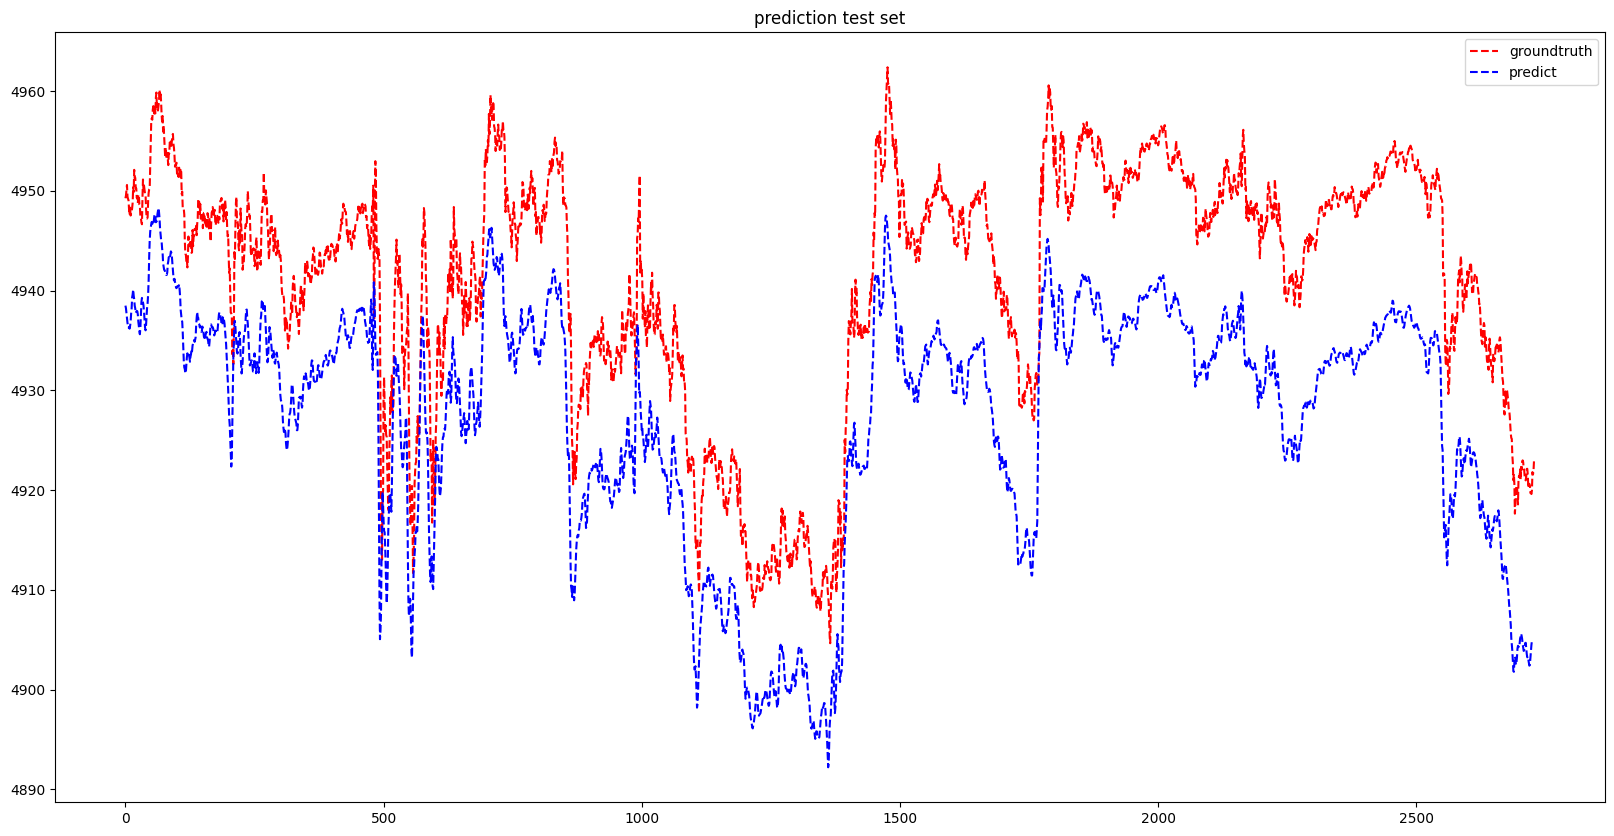

In [28]:
plt.figure(figsize = (20,10))
# test_acc = nn.L1Loss()(prediction, torch.FloatTensor(gt))
plt.plot(data["NDX"][-num_test:].to_numpy(), 'r--')
plt.plot(inverse_prediction[5:], 'b--')
plt.legend(('groundtruth', 'predict'))
plt.title('prediction test set')
plt.show()

In [29]:
stop here

SyntaxError: invalid syntax (<ipython-input-29-a96ba3aab008>, line 1)

In [ ]:

new_model = Pred(10,100,100,1,82,num_layer) # chinh lai cac arguments
new_model.load_state_dict(torch.load('newmodelRLSTM.h5'))

In [ ]:
# load params
for param_tensor in new_model.state_dict():
    print(param_tensor, "\t", new_model.state_dict()[param_tensor].size())

In [ ]:
gt = y_test
prediction = new_model(test_set)
test_acc = nn.L1Loss()(prediction, torch.FloatTensor(gt))
print('test accuracy: ', test_acc)
plt.figure()
plt.plot(gt, 'r--')
plt.plot(prediction.detach().numpy(), 'b--')
plt.legend(('groundtruth', 'predict'))
plt.title('prediction test set')
plt.show()